In [1]:
import numpy as np
import sys, os, shutil
import pandas as pd
import collections as cl
import itertools as it
import timeit
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import copy as cp
import pyprojroot as pr
import scipy.stats as scs
from sklearn.model_selection import StratifiedShuffleSplit
import scipy as sc

In [2]:
#Change directory
os.chdir(pr.here("./Data"))
os.getcwd()

'C:\\Users\\yche465\\Desktop\\AIM 1\\Codes\\PrEP-Traj-Clustering\\Data'

## Create categorical variables used for stratified sampling

In [3]:
#Import appended person-level covariates
PERSON_DATA=pd.read_csv("PersonVars_appended.csv")

In [4]:
#Create class labels (based on quintiles) for continuous attributes
Avg_Copay_Cutoff=20
PERSON_DATA['Age_at_init_CAT']=pd.cut(PERSON_DATA['Age_at_init'],
                                     bins=np.percentile(PERSON_DATA['Age_at_init'],[0,33.3,66.7,100]),
                                     include_lowest=True,
                                     labels=[1,2,3])
PERSON_DATA['Average_copay_CAT']=pd.cut(PERSON_DATA['Average_copay'],
                                     bins=[min(PERSON_DATA['Average_copay']),Avg_Copay_Cutoff,max(PERSON_DATA['Average_copay'])],
                                     include_lowest=True,
                                     labels=[0,1])
PERSON_DATA['Dur_subopt_CAT']=pd.cut(PERSON_DATA['Dur_subopt'],
                                     bins=np.percentile(PERSON_DATA['Dur_subopt'],[0,33.3,66.7,100]),
                                     include_lowest=True,
                                     labels=[1,2,3])
PERSON_DATA['Num_protect_interval_CAT']=pd.cut(PERSON_DATA['Num_protect_interval'],
                                     bins=[1,3,max(PERSON_DATA['Num_protect_interval'])],
                                     include_lowest=True,
                                     labels=[0,1])

In [5]:
print("Num_protect_interval_CAT: MIN =",min(PERSON_DATA.loc[PERSON_DATA['Num_protect_interval_CAT']==0,'Num_protect_interval']))
print("Num_protect_interval_CAT: MAX =",max(PERSON_DATA.loc[PERSON_DATA['Num_protect_interval_CAT']==0,'Num_protect_interval']))
print("Num_protect_interval_CAT: MIN =",min(PERSON_DATA.loc[PERSON_DATA['Num_protect_interval_CAT']==1,'Num_protect_interval']))
print("Num_protect_interval_CAT: MAX =",max(PERSON_DATA.loc[PERSON_DATA['Num_protect_interval_CAT']==1,'Num_protect_interval']))

Num_protect_interval_CAT: MIN = 1
Num_protect_interval_CAT: MAX = 3
Num_protect_interval_CAT: MIN = 4
Num_protect_interval_CAT: MAX = 6


In [6]:
#Check if categorical variable for average copay is created correctly
print("Avg Copay CAT=0: MIN =",min(PERSON_DATA.loc[PERSON_DATA['Average_copay_CAT']==0,'Average_copay']))
print("Avg Copay CAT=0: MAX =",max(PERSON_DATA.loc[PERSON_DATA['Average_copay_CAT']==0,'Average_copay']))
print("Avg Copay CAT=1: MIN =",min(PERSON_DATA.loc[PERSON_DATA['Average_copay_CAT']==1,'Average_copay']))
print("Avg Copay CAT=1: MAX =",max(PERSON_DATA.loc[PERSON_DATA['Average_copay_CAT']==1,'Average_copay']))


Avg Copay CAT=0: MIN = 0.0014466757625993
Avg Copay CAT=0: MAX = 19.999495211848075
Avg Copay CAT=1: MIN = 20.00519949246824
Avg Copay CAT=1: MAX = 181.13185749472308


In [7]:
#Check for missing values
PERSON_DATA.loc[PERSON_DATA.isna().any(axis=1)]

,ID,Age_at_init,Primary_payer,Average_copay,Pharmacy_type,Dur_subopt,Num_protect_interval,IntervalLen_1,IntervalLen_2,IntervalLen_3,Age_at_init_CAT,Average_copay_CAT,Dur_subopt_CAT,Num_protect_interval_CAT
1,93,45.0,1,6.017758,1,73,1,30,NaN,NaN,3,0,2,0
3,128,38.0,0,8.652744,0,95,1,8,NaN,NaN,2,0,3,0
4,155,32.0,0,4.603387,0,83,2,11,9.0,NaN,1,0,2,0
6,206,38.0,0,0.202101,1,80,2,16,7.0,NaN,2,0,2,0
7,207,38.0,1,15.379973,1,90,1,13,NaN,NaN,2,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12995,191919,40.0,0,10.450687,0,83,1,20,NaN,NaN,2,0,2,0
12996,191934,25.0,0,27.274763,1,83,1,20,NaN,NaN,1,1,2,0
12997,191941,40.0,0,2.147359,1,83,1,20,NaN,NaN,2,0,2,0
12998,191955,33.0,0,29.775469,0,93,1,10,NaN,NaN,2,1,3,0


## Implement stratified sampling

In [8]:
#Import the original sero-protection dataset 
SeroProtect = np.loadtxt('SeroProtect_13k.txt', usecols=range(104), delimiter=",")
orig_size=len(SeroProtect)

#Import the original PMC dataset 
PMC=np.loadtxt('PMC_13k.txt', usecols=range(103), delimiter=",")

In [9]:
#Check sample size of individual stratum 
pd.options.display.max_rows = 999
working_size=4000
strat_cols=['Age_at_init_CAT','Average_copay_CAT','Primary_payer','Dur_subopt_CAT']

print(PERSON_DATA.groupby(strat_cols).size()/orig_size*working_size)

Age_at_init_CAT  Average_copay_CAT  Primary_payer  Dur_subopt_CAT
1                0                  0              1                 249.846154
                                                   2                 262.461538
                                                   3                 248.307692
                                    1              1                  47.384615
                                                   2                  45.230769
                                                   3                  42.461538
                                    2              1                  17.230769
                                                   2                  17.538462
                                                   3                  16.923077
                 1                  0              1                 155.692308
                                                   2                 142.153846
                                                   3  

In [10]:
#Import objects used in stratification sampling
import pickle
os.chdir(pr.here("./Export"))
pickle_in=open("Descript_Orig","rb")
loadobj=pickle.load(pickle_in)
colnames=loadobj['colnames']
cont_vars=loadobj['cont_vars']
cat_vars=loadobj['cat_vars']
joint_list=loadobj['joint_list']
joint_dist_stat_orig=loadobj['joint_dist_stat']
colname_label={'Age_at_init':"Age at PrEP initiation",
'Primary_payer':"Primary payer",
'Average_copay':"Monthly average copay",
'Pharmacy_type':"Pharmacy type",
'Dur_subopt':'Total time under sub-optimal PrEP protection',
'Num_protect_interval':"Number of PrEP protective interval"}

cat_levels={"Age_at_init_cat":[1,2,3,4,5],
        "Average_copay_cat":[1,2,3],
        'Dur_subopt_cat':[1,2,3],
        'Num_protect_interval_cat':[1,2],
        'Primary_payer': [0,1,2],
        'Pharmacy_type':[0,1]}

In [11]:
#Similarity ranking function
def sim_rank(strat_work_set):
    #create categorical version of continuous variables
    strat_work_set["Age_at_init_cat"]=pd.cut(strat_work_set['Age_at_init'],
                                         bins=[18,24,29,39,49,max(strat_work_set['Age_at_init'])],
                                         include_lowest=True,
                                         labels=[1,2,3,4,5])
    strat_work_set["Average_copay_cat"]=pd.cut(strat_work_set['Average_copay'],
                                         bins=[0,0.01,20,max(strat_work_set['Average_copay'])],
                                         include_lowest=True,
                                         labels=[1,2,3])
    strat_work_set['Dur_subopt_cat']=pd.cut(strat_work_set['Dur_subopt'],
                                         bins=np.percentile(strat_work_set['Dur_subopt'],[0,33.3,66.7,100]),
                                         include_lowest=True,
                                         labels=[1,2,3])
    strat_work_set['Num_protect_interval_cat']=pd.cut(strat_work_set['Num_protect_interval'],
                                         bins=[1,3,max(strat_work_set['Num_protect_interval'])],
                                         include_lowest=True,
                                         labels=[1,2])
    #strat_work_set['Num_protect_interval_cat']=pd.cut(strat_work_set['Num_protect_interval'],
    #                                     bins=[1,3,6,9,max(strat_work_set['Num_protect_interval'])],
    #                                     include_lowest=True,
    #                                     labels=[1,2,3,4])
    #########################################################################################
    #Compute joint distribution statistics 
    joint_dist_stat_sampled=dict()
    DICT_TITLE=list()

    for i in range(len(joint_list)):
        X=joint_list[i][0]
        Y=joint_list[i][1]
        Xlabel=colname_label[X]
        Ylabel=colname_label[Y]
        dict_title=X+ "/"+Y
        DICT_TITLE.append(dict_title)

        ##Both variables are continuous 
        if X in cont_vars and Y in cont_vars:
            joint_dist_stat_sampled[dict_title]=sc.stats.spearmanr(strat_work_set[X],strat_work_set[Y])[0]

        ##Both variables are categorical 
        if X in cat_vars and Y in cat_vars:
            ct=pd.crosstab(strat_work_set[X],strat_work_set[Y], rownames=[Xlabel],colnames=[Ylabel],dropna=True,normalize=True)
            ct = ct.reindex(index=cat_levels[X], columns=cat_levels[Y], fill_value=0)
            joint_dist_stat_sampled[dict_title]=ct

        ##one variable is categorical and the other is continuous --> categorize the continuous variable and then cross tabulation 
        if X in cat_vars and Y in cont_vars:
            Y=Y+"_cat"
            ct=pd.crosstab(strat_work_set[X],strat_work_set[Y], rownames=[Xlabel],colnames=[Ylabel],dropna=True,normalize=True)
            ct = ct.reindex(index=cat_levels[X], columns=cat_levels[Y], fill_value=0)
            joint_dist_stat_sampled[dict_title]=ct

        if Y in cat_vars and X in cont_vars:
            X=X+"_cat"
            ct=pd.crosstab(strat_work_set[X],strat_work_set[Y], rownames=[Xlabel],colnames=[Ylabel],dropna=True,normalize=True)
            ct = ct.reindex(index=cat_levels[X], columns=cat_levels[Y], fill_value=0)
            joint_dist_stat_sampled[dict_title]=ct
    ##################################################################################################
    # Compute distance statistics (comparing original vs sampled dataset)
    Distance_both_cont=list()
    Distance_one_cat=list()

    for i in DICT_TITLE:
        if isinstance(joint_dist_stat_orig[i],float):
            Distance_both_cont.append((joint_dist_stat_orig[i]-joint_dist_stat_sampled[i])**2)
        else:
            RMSE=np.matrix((joint_dist_stat_orig[i]-joint_dist_stat_sampled[i])**2).mean()
            Distance_one_cat.append(RMSE)

    # compute RMSE for spearmnan's correlation coefficients (across continuous var pairs)
    Both_cont_distance=np.mean(Distance_both_cont)
    # compute average RMSE for pairs that have at least one categorical variables (each RMSE is computed for each var pair) 
    One_cat_distance=np.mean(Distance_one_cat)
    return Both_cont_distance, One_cat_distance, joint_dist_stat_sampled


In [12]:
np.random.seed(15346)
Seed_vector=np.random.randint(0,999999,100)

#iterative sampling to obtain best seed number
Rank=pd.DataFrame()
for SEEDNUM in Seed_vector:
    #Conduct stratified sampling
    stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=working_size/orig_size, random_state=SEEDNUM)

    for nonwork_index, work_index in stratified_split.split(PERSON_DATA,PERSON_DATA[strat_cols]):
        strat_nonwork_set = PERSON_DATA.loc[nonwork_index]
        strat_work_set = PERSON_DATA.loc[work_index]

    
    Both_cont_distance, One_cat_distance, joint_dist_stat_sampled=sim_rank(strat_work_set)
    rk=pd.DataFrame({"Seed":SEEDNUM, "Cont_Score":Both_cont_distance,"Cat_Score":One_cat_distance},index=[0])
    Rank=pd.concat([Rank,rk])

In [13]:
row_end=Rank.shape[0]+1
Rank1=Rank.sort_values("Cont_Score")
Rank1["Cont_Score_Rank"]=np.arange(1,row_end)
Rank2=Rank1.sort_values("Cat_Score")
Rank2["Cat_Score_Rank"]=np.arange(1,row_end)
Rank2["Combined_Rank"]=Rank2["Cont_Score_Rank"]*6/15+Rank2["Cat_Score_Rank"]*9/15
Rank3=Rank2.sort_values("Combined_Rank")
Best_seed=np.array(Rank3["Seed"])[0]

del strat_work_set
del work_index

In [14]:
#Use the best seed number to sample data
if 'Num_protect_interval_CAT' in strat_cols:
    strat_cols.remove('Num_protect_interval_CAT')

stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=working_size/orig_size, random_state=Best_seed)

for nonwork_index, work_index in stratified_split.split(PERSON_DATA,PERSON_DATA[strat_cols]):
    strat_nonwork_set = PERSON_DATA.loc[nonwork_index]
    strat_work_set = PERSON_DATA.loc[work_index]
    
Both_cont_distance, One_cat_distance, joint_dist_stat_sampled=sim_rank(strat_work_set)


In [15]:
#Check the presence of duplicated ID
len(np.unique(strat_work_set['ID']))!=working_size

False

In [16]:
strat_cols.append('Num_protect_interval_CAT')

In [17]:
#Check distributions of columns between original and sampled datasets
strat_cols
for i in strat_cols:
    X=pd.DataFrame()
    X['Original']=PERSON_DATA[i].value_counts() / orig_size
    X['Working']=strat_work_set[i].value_counts() / working_size
    print(i)
    print(X)

Age_at_init_CAT
   Original  Working
1  0.373923  0.37375
2  0.320846  0.32075
3  0.305231  0.30550
Average_copay_CAT
   Original  Working
0  0.628308    0.628
1  0.371692    0.372
Primary_payer
   Original  Working
0  0.804923   0.8045
1  0.145769   0.1460
2  0.049308   0.0495
Dur_subopt_CAT
   Original  Working
1  0.338231  0.33825
2  0.332923  0.33300
3  0.328846  0.32875
Num_protect_interval_CAT
   Original  Working
0  0.966462  0.96375
1  0.033538  0.03625


## Export stratified-sampled PrEP seroprotection matrix

In [18]:
Sampled_SeroProtect=SeroProtect[work_index]

# Export sampled PrEP trajectories matrix
f= open("SeroProtect_4k.txt","w+")
for i in range(len(Sampled_SeroProtect)):
    for j in range(104):
        if j == 103:
            f.write("%s\n" % (Sampled_SeroProtect[i][j]))
        else:
            f.write("%s," % (Sampled_SeroProtect[i][j]))
f.close()

## Descriptive statistics: sampled dataset

In [19]:
del PERSON_DATA
del colnames

### _Univariate distributions_

In [20]:
#univariate distributions for continuous variables
univ_mean=[]
univ_SD=[]
univ_median=[]
univ_IQR25=[]
univ_IQR75=[]
for i in cont_vars:
    univ_mean.append(round(np.nanmean(strat_work_set[i]),1))
    univ_SD.append(round(np.nanstd(strat_work_set[i]),1))
    univ_median.append(round(np.nanmedian(strat_work_set[i]),1))
    univ_IQR25.append(round(np.nanquantile(strat_work_set[i], 0.25),1))
    univ_IQR75.append(round(np.nanquantile(strat_work_set[i], 0.75),1))
    
cont_vars_label=["Age at PrEP initiation",
                 "Monthly average copay",
                 "Total time under sub-optimal PrEP protection",
                 "Number of PrEP protective interval",
                 "Length of 1st PrEP protective interval",
                 "Length of 2nd PrEP protective interval",
                 "Length of 3rd PrEP protective interval"]

In [21]:
univar_cont_sampled=pd.DataFrame({"Attribute":cont_vars_label,
                            "Mean":univ_mean,
                            "SD": univ_SD,
                            "Median": univ_median,
                            "IQR:25%": univ_IQR25,
                            "IQR:75%": univ_IQR75})

In [22]:
univar_cont_sampled

,Attribute,Mean,SD,Median,IQR:25%,IQR:75%
0,Age at PrEP initiation,35.9,8.9,35.0,29.0,42.0
1,Monthly average copay,20.4,20.9,13.9,5.7,27.7
2,Total time under sub-optimal PrEP protection,65.6,26.6,73.0,45.0,90.0
3,Number of PrEP protective interval,1.5,0.8,1.0,1.0,2.0
4,Length of 1st PrEP protective interval,26.3,21.5,17.0,11.0,35.0
5,Length of 2nd PrEP protective interval,22.8,17.6,17.0,10.0,31.0
6,Length of 3rd PrEP protective interval,17.0,12.9,13.0,8.0,23.0


In [23]:
cat_vars

['Primary_payer', 'Pharmacy_type']

In [24]:
#Univariate distribution for categorical variables
if "Num_protect_interval" not in cat_vars:
    cat_vars.append("Num_protect_interval")

cat_vars_label=["Primary payer","Pharmacy type","Number of PrEP protective interval"]
univar_cat_sampled=pd.DataFrame()
for i in range(len(cat_vars)):
    freq=dict(cl.Counter(strat_work_set[cat_vars[i]]))
    freq_tab = pd.DataFrame(list(freq.items()),columns = ["Level",'N']).sort_values(by="Level") 
    freq_tab['%']=np.around(freq_tab['N']/len(strat_work_set)*100,1)
    freq_tab.insert(0,"Variable",cat_vars_label[i])
    freq_tab.index=[''] * len(freq)
    univar_cat_sampled=pd.concat([univar_cat_sampled,freq_tab])

if "Num_protect_interval" in cat_vars:
    cat_vars.remove("Num_protect_interval")

In [25]:
univar_cat_sampled

,Variable,Level,N,%
,Primary payer,0,3218,80.4
,Primary payer,1,584,14.6
,Primary payer,2,198,5.0
,Pharmacy type,0,2000,50.0
,Pharmacy type,1,2000,50.0
,Number of PrEP protective interval,1,2544,63.6
,Number of PrEP protective interval,2,902,22.6
,Number of PrEP protective interval,3,409,10.2
,Number of PrEP protective interval,4,126,3.2
,Number of PrEP protective interval,5,19,0.5


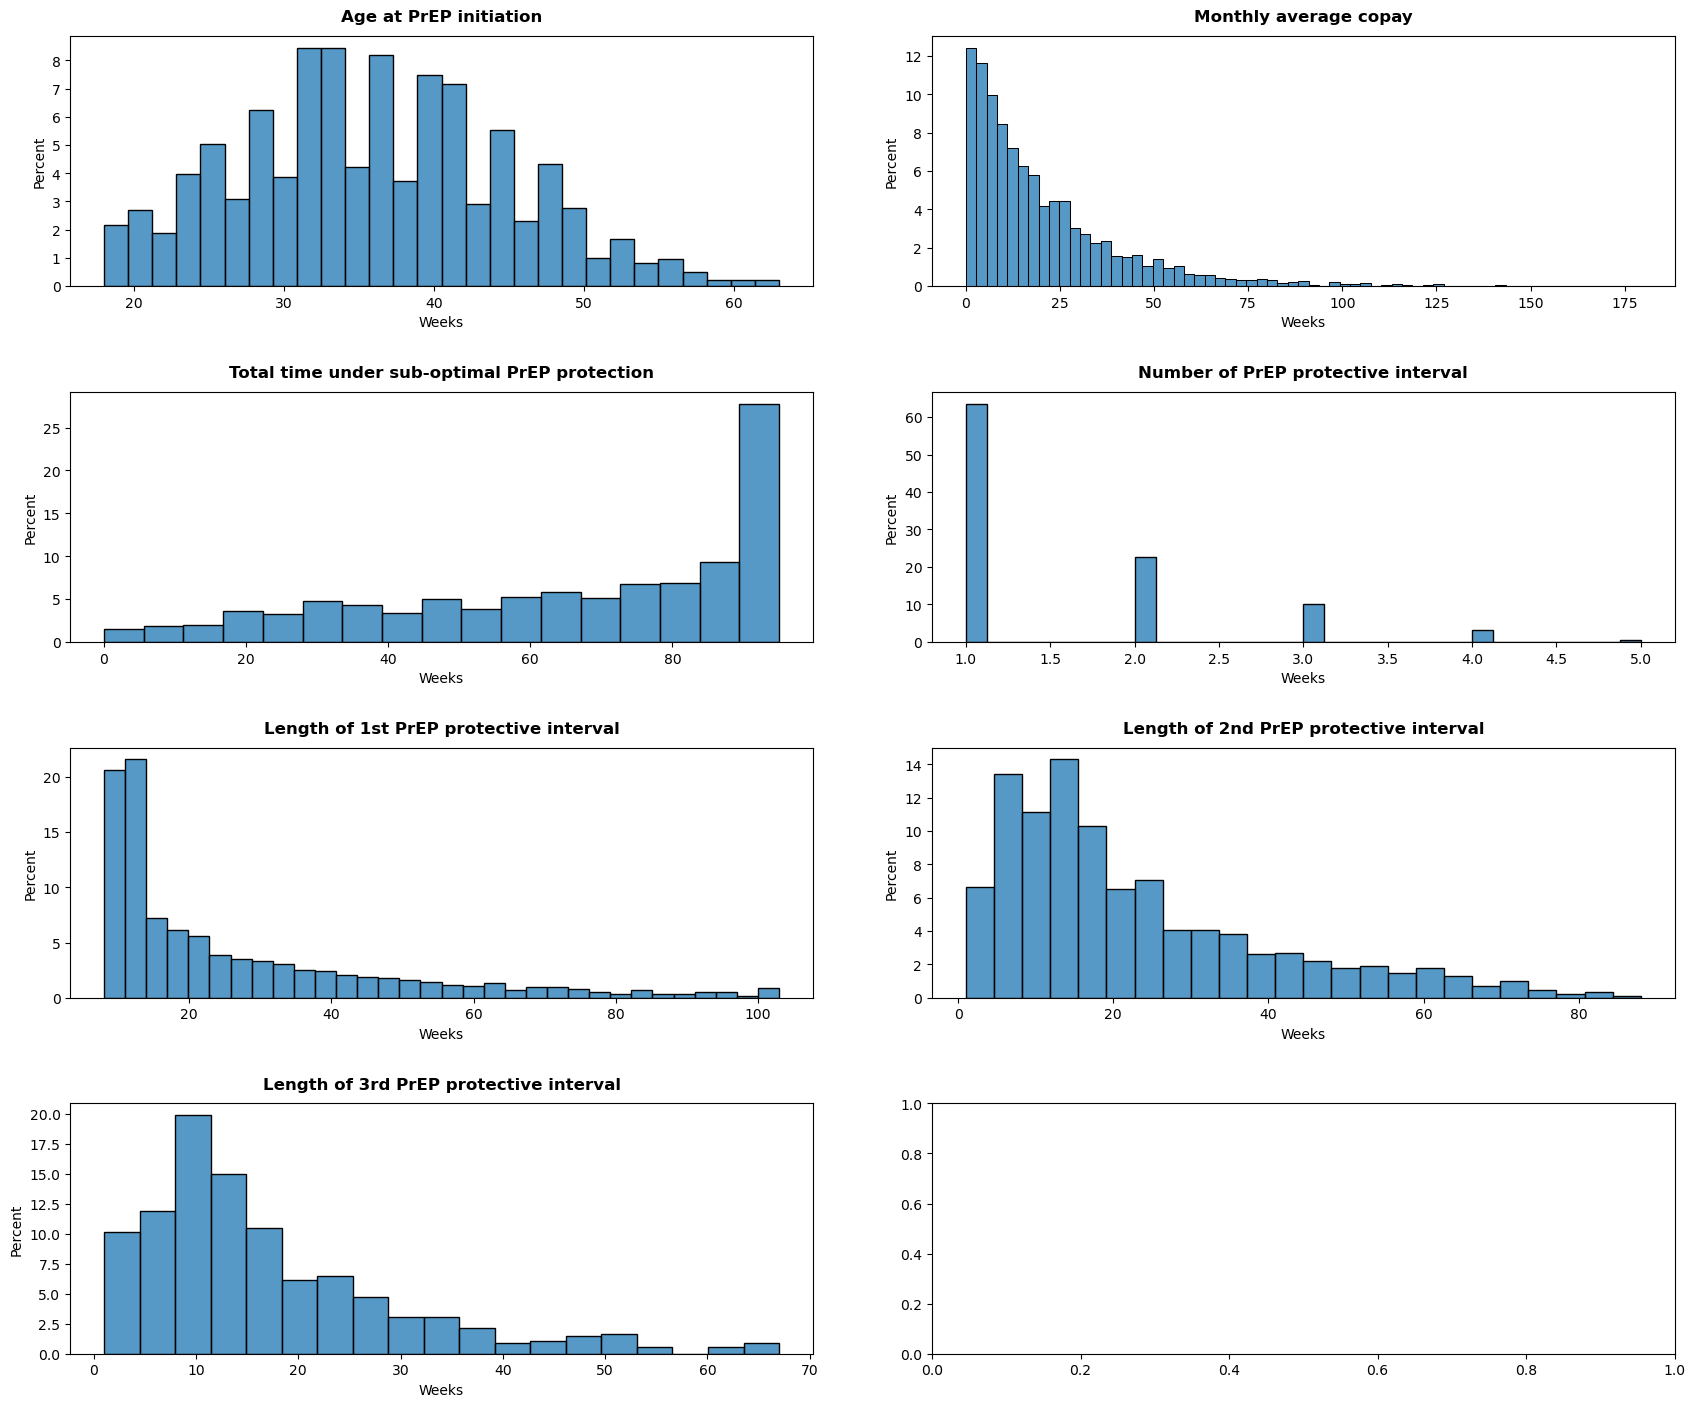

In [26]:
#univariate histograms
os.chdir(pr.here("./Figures"))

fig,ax =  plt.subplots(4,2,figsize=(18,15))
fig.tight_layout(pad=5.5)
col_arr=[0,1]*4
row_arr=np.repeat([0,1,2,3],2, axis=0)

for i in range(len(cont_vars)):
    plot=sns.histplot(data=strat_work_set,x=cont_vars[i],ax=ax[row_arr[i]][col_arr[i]],stat="percent")
    plot.set(xlabel="Weeks")
    plot.set_title(cont_vars_label[i],fontweight='bold', y=1.025)

plt.savefig('Univ_distplot_Sampled.png', bbox_inches='tight')

### _Joint distributions_

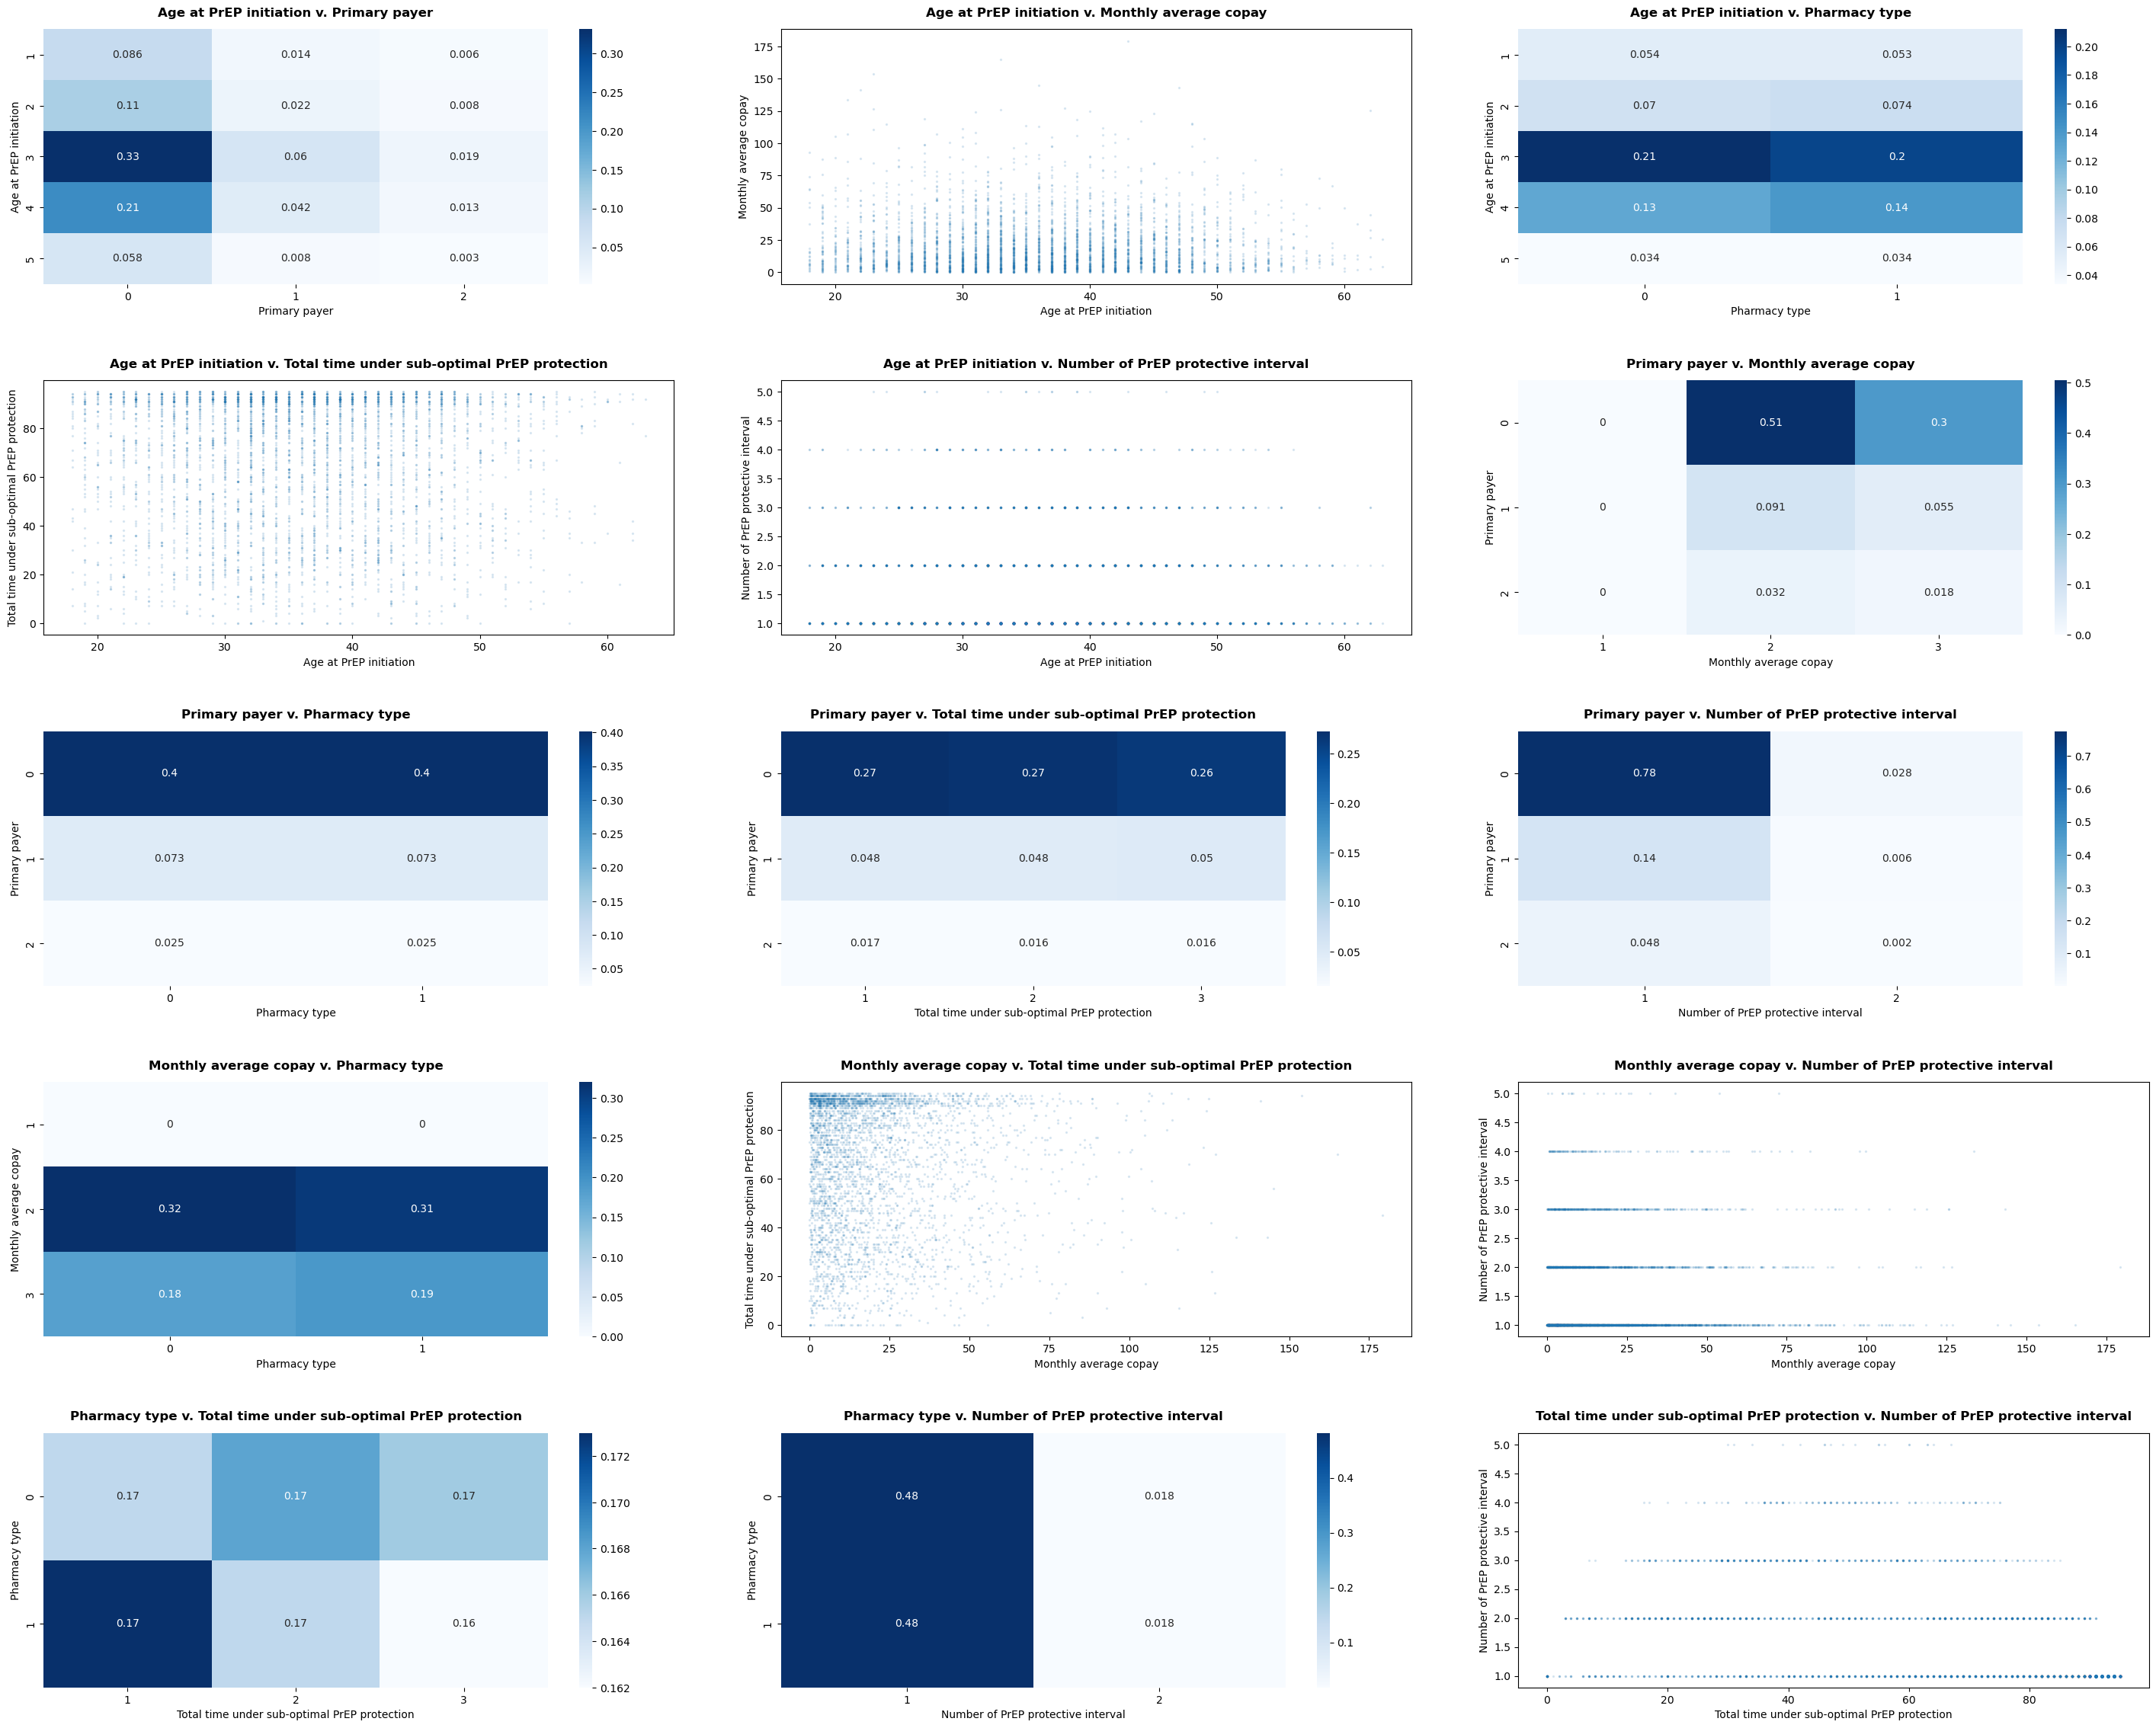

In [27]:
fig,ax =  plt.subplots(5,3,figsize=(30,24))
fig.tight_layout(pad=7)
col_arr=[0,1,2]*5
row_arr=np.repeat([0,1,2,3,4],3, axis=0)

for i in range(len(joint_list)):
    X=joint_list[i][0]
    Y=joint_list[i][1]
    Xlabel=colname_label[X]
    Ylabel=colname_label[Y]
    TITLE=Xlabel+" v. "+Ylabel
    dict_title=X+ "/"+Y
    ##Both variables are continuous --> scatter plots
    if X in cont_vars and Y in cont_vars:     
        ax[row_arr[i]][col_arr[i]].scatter(strat_work_set[X],strat_work_set[Y],s=2,alpha=0.125)
        ax[row_arr[i]][col_arr[i]].set_title(TITLE,fontweight="bold",y=1.025)
        ax[row_arr[i]][col_arr[i]].set_xlabel(Xlabel)
        ax[row_arr[i]][col_arr[i]].set_ylabel(Ylabel)
    
    ##Both variables are categorical --> cross tabulation 
    if X in cat_vars and Y in cat_vars:
        ct=joint_dist_stat_sampled[dict_title]
        plot=sns.heatmap(ct.round(3),cmap="Blues", annot=True, cbar=True, ax=ax[row_arr[i]][col_arr[i]])
        plot.set_title(TITLE,fontweight='bold', y=1.025)
        
    ##one variable is categorical and the other is continuous --> categorize the continuous variable and then cross tabulation 
    if X in cat_vars and Y in cont_vars:
        Y=Y+"_cat"
        ct=joint_dist_stat_sampled[dict_title]
        plot=sns.heatmap(ct.round(3),cmap="Blues", annot=True, cbar=True,ax=ax[row_arr[i]][col_arr[i]])
        plot.set_title(TITLE,fontweight='bold', y=1.025)
        
    if Y in cat_vars and X in cont_vars:
        X=X+"_cat"
        ct=joint_dist_stat_sampled[dict_title]
        plot=sns.heatmap(ct.round(3),cmap="Blues", annot=True, cbar=True,ax=ax[row_arr[i]][col_arr[i]])
        plot.set_title(TITLE,fontweight='bold', y=1.025)

plt.savefig('bivar_distplot_Sampled.png', bbox_inches='tight')

In [28]:
# Obtain covarinace for continuous variable pairs
Cont_Data_sampled=strat_work_set[['Age_at_init','Average_copay','Dur_subopt','Num_protect_interval']]
Bivar_CoV_sampled=Cont_Data_sampled.cov()
Bivar_CoV_sampled

,Age_at_init,Average_copay,Dur_subopt,Num_protect_interval
Age_at_init,78.933481,-0.449974,-0.420910,0.111400
Average_copay,-0.449974,436.529061,-11.735308,0.279695
Dur_subopt,-0.420910,-11.735308,706.904064,-9.629322
Num_protect_interval,0.111400,0.279695,-9.629322,0.698782


In [29]:
#Export descriptive statistics (original data)
os.chdir(pr.here("./Export"))
Descript_sampled={"Univ. Continuous":univar_cont_sampled, 
                  "Univ. Categorical":univar_cat_sampled, 
                  "Bivar. Continuous CoV":Bivar_CoV_sampled,
                  "joint_dist_stat":joint_dist_stat_sampled}
import pickle
pickle_out=open("Descript_sampled","wb")
pickle.dump(Descript_sampled,pickle_out)
pickle_out.close()

In [30]:
pickle_in=open("Descript_sampled","rb")
loadobj=pickle.load(pickle_in)
Descript_sampled2=loadobj
Descript_sampled2

{'Univ. Continuous':                                       Attribute  Mean    SD  Median  IQR:25%  \
 0                        Age at PrEP initiation  35.9   8.9    35.0     29.0   
 1                         Monthly average copay  20.4  20.9    13.9      5.7   
 2  Total time under sub-optimal PrEP protection  65.6  26.6    73.0     45.0   
 3            Number of PrEP protective interval   1.5   0.8     1.0      1.0   
 4        Length of 1st PrEP protective interval  26.3  21.5    17.0     11.0   
 5        Length of 2nd PrEP protective interval  22.8  17.6    17.0     10.0   
 6        Length of 3rd PrEP protective interval  17.0  12.9    13.0      8.0   
 
    IQR:75%  
 0     42.0  
 1     27.7  
 2     90.0  
 3      2.0  
 4     35.0  
 5     31.0  
 6     23.0  ,
 'Univ. Categorical':                             Variable  Level     N     %
                        Primary payer      0  3218  80.4
                        Primary payer      1   584  14.6
                        P